# Recluster subset

In [1]:
# Get the subset ids
import scanpy as sc
import matplotlib.pyplot as plt
# import sclitr as sl
import math
import numpy as np
import pandas as pd
import seaborn as sns
import symphonypy as sp
import anndata as ad


DATA_PATH = "/home/felix/data/placodal"

/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/anndata/utils.py:429: 

In [6]:
adata_conc = sc.read_h5ad(f"{DATA_PATH}/anndatas/cranial_placodal_integrated_clonal_clusters.h5ad")

In [7]:
adata_conc.shape

(171093, 5000)

In [8]:
selected_clusters=["24",
                    "25",
                    "36",
                    "66",
                    "83",
                    "78"
                     ]
subset = adata_conc[adata_conc.obs["leiden_3"].isin(selected_clusters)].copy()


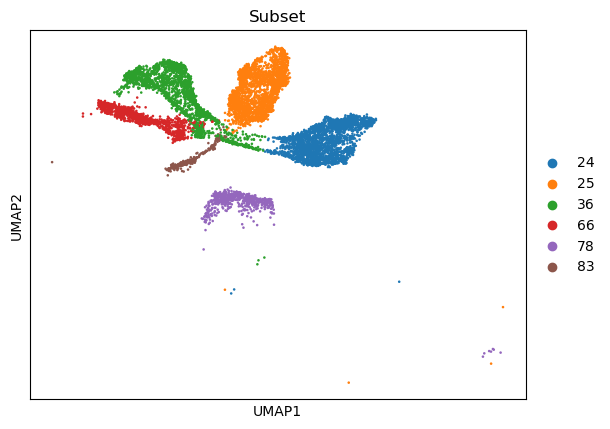

In [9]:
sc.pl.umap(subset, color="leiden_3",  title=f"Subset")

In [10]:
del adata_conc

In [11]:
# Get the original concatenated data
E11_placodes = sc.read_h5ad(f"{DATA_PATH}/anndatas_counts/new_data_reference_E11_placodal.h5ad")
E11_cranial = sc.read_h5ad(f"{DATA_PATH}/anndatas_counts/reference_E11_cranial.h5ad")

In [12]:
# Find the common var_names
common_vars = E11_placodes.var_names.intersection(E11_cranial.var_names)

# Subset both AnnData objects to only include the common var_names
adata1_subset = E11_placodes[:, common_vars]
adata2_subset = E11_cranial[:, common_vars]

# For each different column, create a new combined column in both objects
for col in ['E7.5:clones', 'E8.5:clones']:
    new_col_name = f"combined_{col}"
    
    # If column exists in first dataset
    if col in adata1_subset.obs.columns:
        adata1_subset.obs[new_col_name] = adata1_subset.obs[col]
        adata2_subset.obs[new_col_name] = "NA"
    
    # If column exists in second dataset
    if col in adata2_subset.obs.columns:
        adata2_subset.obs[new_col_name] = adata2_subset.obs[col]
        adata1_subset.obs[new_col_name] = "NA"

# Concatenate the subsetted AnnData objects
concatenated = ad.concat([adata1_subset, adata2_subset], axis=0)

# Merge the two clonal id attributes
concatenated.obs["clone_id"] = concatenated.obs["combined_E7.5:clones"].astype(str)
concatenated.obs.loc[concatenated.obs['clone_id'] == "NA", 'clone_id'] = concatenated.obs.loc[concatenated.obs['clone_id'] == "NA", 'combined_E8.5:clones']

/tmp/ipykernel_13736/3817451050.py:14: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata1_subset.obs[new_col_name] = adata1_subset.obs[col]
/tmp/ipykernel_13736/3817451050.py:15: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata2_subset.obs[new_col_name] = "NA"


In [13]:
# Subset based on annotations
obs_mask = np.isin(concatenated.obs_names, list(subset.obs_names))
concatenated = concatenated[obs_mask, :] # Subset for only the selected annotations

In [14]:
del E11_placodes
del E11_cranial

In [15]:
# Remove cell cycle genes
g2m_genes = list(pd.read_csv("/home/sergey/data/additional/cell_cycle_genes/G2M_phase.txt", names=["gene"]).gene)
g2m_genes = [gene[0].upper() + gene[1:].lower() for gene in g2m_genes]
s_genes = list(pd.read_csv("/home/sergey/data/additional/cell_cycle_genes/S_phase.txt", names=["gene"]).gene)
s_genes = [gene[0].upper() + gene[1:].lower() for gene in s_genes]
var_mask = ~np.isin(concatenated.var_names, g2m_genes)
concatenated = concatenated[:, var_mask] # Remove g2m genes
var_mask = ~np.isin(concatenated.var_names, s_genes)
concatenated = concatenated[:, var_mask] # Remove g2m genes

In [16]:
concatenated.var["mt"] = concatenated.var_names.str.startswith("mt-")
# ribosomal genes
concatenated.var["ribo"] = concatenated.var_names.str.startswith(("Rps", "Rpl"))
# hemoglobin genes
concatenated.var["hb"] = concatenated.var_names.str.contains("^Hb[^(P)]")
sc.pp.calculate_qc_metrics(
    concatenated, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

/tmp/ipykernel_13736/3651622418.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  concatenated.var["mt"] = concatenated.var_names.str.startswith("mt-")


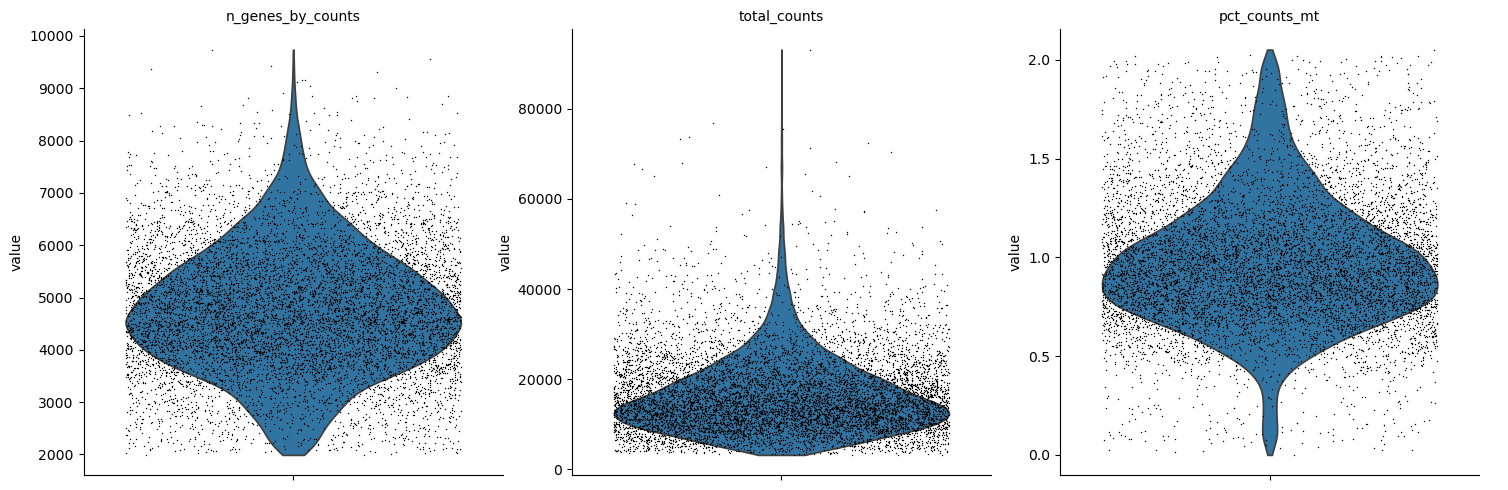

In [17]:
sc.pl.violin(
    concatenated,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [18]:
print(len(concatenated.var_names))
sc.pp.filter_cells(concatenated, min_genes=100)
sc.pp.filter_genes(concatenated, min_cells=3)
print(len(concatenated.var_names))


56597
30355


In [19]:
sc.pp.scrublet(concatenated, batch_key="sample_id")

In [20]:
concatenated

AnnData object with n_obs × n_vars = 8834 × 30355
    obs: 'batch', 'sample_id', 'location', 'devtime', 'plasmids', 'injection', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'combined_E7.5:clones', 'combined_E8.5:clones', 'clone_id', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'log1p_total_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'predicted_doublet'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet'
    layers: 'counts'

In [21]:
concatenated = concatenated[concatenated.obs["predicted_doublet"] == False]

In [22]:
concatenated

View of AnnData object with n_obs × n_vars = 8809 × 30355
    obs: 'batch', 'sample_id', 'location', 'devtime', 'plasmids', 'injection', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'combined_E7.5:clones', 'combined_E8.5:clones', 'clone_id', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'log1p_total_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'predicted_doublet'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet'
    layers: 'counts'

In [23]:
# Continue integration

concatenated.layers["counts"] = concatenated.X.copy()
sc.pp.normalize_total(concatenated, target_sum=1e4)
sc.pp.log1p(concatenated)
sc.pp.highly_variable_genes(
    concatenated,
    flavor="seurat_v3",
    layer="counts",
    n_top_genes=5000,
)
concatenated.raw = concatenated

concatenated = concatenated[:, concatenated.var.highly_variable]
sc.pp.scale(concatenated, max_value=10)
sc.pp.pca(concatenated, n_comps=30)

/tmp/ipykernel_13736/243248983.py:3: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  concatenated.layers["counts"] = concatenated.X.copy()
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [24]:
sp.pp.harmony_integrate(concatenated, key="batch", max_iter_harmony=30, verbose=True)
sc.pp.neighbors(concatenated, n_neighbors=20, use_rep="X_pca_harmony")
sc.tl.umap(concatenated)

2025-04-08 10:02:14,433 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Harmony integration with harmonypy is preforming.


2025-04-08 10:02:16,093 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-04-08 10:02:16,168 - harmonypy - INFO - Iteration 1 of 30
2025-04-08 10:02:18,874 - harmonypy - INFO - Iteration 2 of 30
2025-04-08 10:02:21,976 - harmonypy - INFO - Iteration 3 of 30
2025-04-08 10:02:25,040 - harmonypy - INFO - Iteration 4 of 30
2025-04-08 10:02:27,997 - harmonypy - INFO - Iteration 5 of 30
2025-04-08 10:02:30,765 - harmonypy - INFO - Converged after 5 iterations
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/tmp/ipykernel_13736/1959267574.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(concatenated, key_added=f"re_leiden_{resolution}", resolution=resolution)


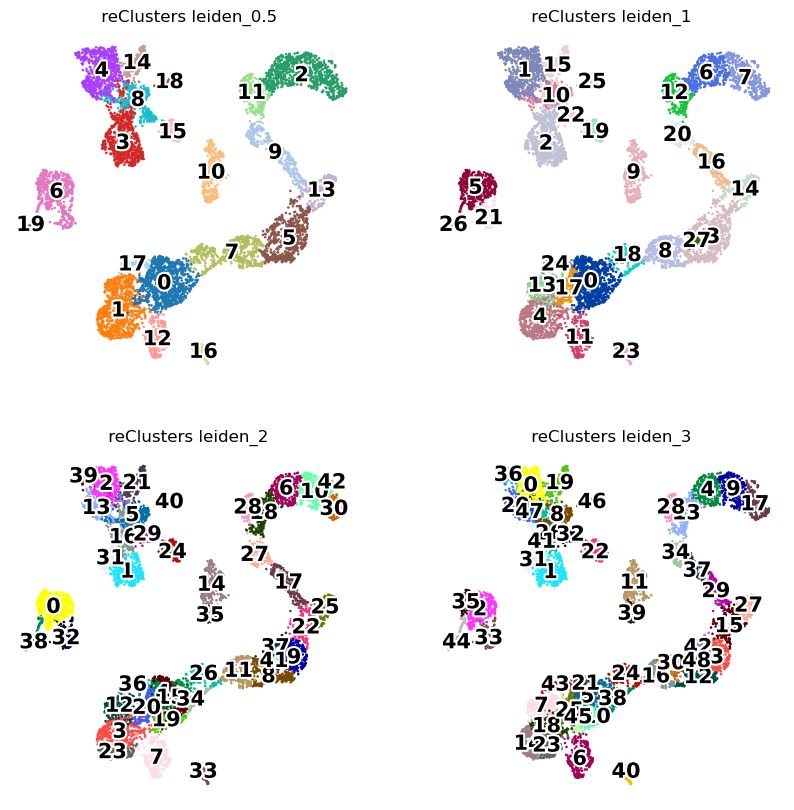

In [25]:
fig, axes = plt.subplots(ncols=2, nrows=2 , figsize=(10, 10))

col=0
row=0
for resolution in [0.5, 1, 2, 3,]:
    sc.tl.leiden(concatenated, key_added=f"re_leiden_{resolution}", resolution=resolution)

    sc.pl.umap(
        concatenated,
        color=f"re_leiden_{str(resolution)}",
        frameon=False,
        title=f" reClusters leiden_{str(resolution)}",
        legend_loc="on data",
        legend_fontsize=15,
        legend_fontoutline=3,
        show=False,
        ax=axes[col][row]
    )
    if row == 0:
        row += 1
    else:
        row -= 1
        col += 1

In [26]:
concatenated.obs["annotation"] = subset.obs["annotation"]

KeyError: 'annotation'

In [ ]:
subset.obs["annotation"]

In [ ]:
concatenated.obs["annotation"] 

In [ ]:
subset.obs

In [27]:
# Transfer clonal clusters and save
concatenated.obs["clones_clusters_2.5"] = subset.obs["clones_clusters_2.5"]
concatenated.obs["clones_clusters_3"] = subset.obs["clones_clusters_3"]
concatenated.obs["clones_clusters_4"] = subset.obs["clones_clusters_4"]
# Remove old clusters
concatenated = concatenated[~concatenated.obs.index.isin(['clones_cluster_0.5']), :]
concatenated = concatenated[~concatenated.obs.index.isin(['clones_cluster_1']), :]
concatenated = concatenated[~concatenated.obs.index.isin(['clones_cluster_2']), :]

In [ ]:
 sc.pl.umap(
        concatenated,
        color="annotation",
        frameon=False,
    )

In [28]:
# Save 
concatenated.write_h5ad(f"{DATA_PATH}/anndatas/reclustered_subset_doublets_removed.h5ad")